In [3]:
!pip install kagglehub opencv-python tensorflow

In [4]:
import os
import cv2
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

In [5]:
path = kagglehub.dataset_download("mathiasviborg/uta-rldd-videos-cropped-by-faces")
print("Dataset Path:", path)

Dataset Path: /Users/sit23ad057/.cache/kagglehub/datasets/mathiasviborg/uta-rldd-videos-cropped-by-faces/versions/1


In [6]:
SEQ_LEN = 10
IMG_SIZE = 64

DATA_FOLDER = os.path.join(
    path,
    "UTA-RLDD Face Cropped Video",
    "len10"
)

In [7]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < SEQ_LEN:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame / 255.0
        frames.append(frame)

    cap.release()

    if len(frames) == SEQ_LEN:
        return np.array(frames)
    return None

In [8]:
X = []
y = []

video_extensions = (".mp4", ".mov", ".avi", ".mkv")

subjects = os.listdir(DATA_FOLDER)

for subject in subjects:
    subject_path = os.path.join(DATA_FOLDER, subject)
    if not os.path.isdir(subject_path):
        continue

    for label_folder in ["0", "10"]:
        label_path = os.path.join(subject_path, label_folder)
        if not os.path.isdir(label_path):
            continue

        for file in os.listdir(label_path):
            if file.lower().endswith(video_extensions):
                video_path = os.path.join(label_path, file)

                seq = load_video(video_path)
                if seq is not None:
                    X.append(seq)
                    y.append(0 if label_folder == "0" else 1)

X = np.array(X)
y = np.array(y)

print("Dataset:", X.shape, y.shape)

Dataset: (7049, 10, 64, 64, 3) (7049,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)

(5639, 10, 64, 64, 3) (1410, 10, 64, 64, 3)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

SEQ_LEN = 10
IMG_SIZE = 64

model = Sequential([
    Input(shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(Conv2D(32,(3,3),activation='relu'),
                    input_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),

    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),

    TimeDistributed(Flatten()),

    LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(
    learning_rate=0.0001,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/sit23ad057/Desktop/drowsiness_dl/venv/lib/python3.13/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 62, 62, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 29, 29, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,793 (12.40 MB)

 Trainable params: 3,249,601 (12.40 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 140s 197ms/step - accuracy: 0.9920 - loss: 0.0384 - val_accuracy: 0.9936 - val_loss: 0.0159
Epoch 2/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 137s 194ms/step - accuracy: 0.9961 - loss: 0.0220 - val_accuracy: 0.9922 - val_loss: 0.0209
Epoch 3/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 136s 192ms/step - accuracy: 0.9975 - loss: 0.0130 - val_accuracy: 0.9979 - val_loss: 0.0122
Epoch 4/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 136s 193ms/step - accuracy: 0.9980 - loss: 0.0108 - val_accuracy: 0.9965 - val_loss: 0.0097
Epoch 5/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 136s 193ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9936 - val_loss: 0.0161


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step
[[706   2]
 [  3 699]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       708
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1410
   macro avg       1.00      1.00      1.00      1410
weighted avg       1.00      1.00      1.00      1410



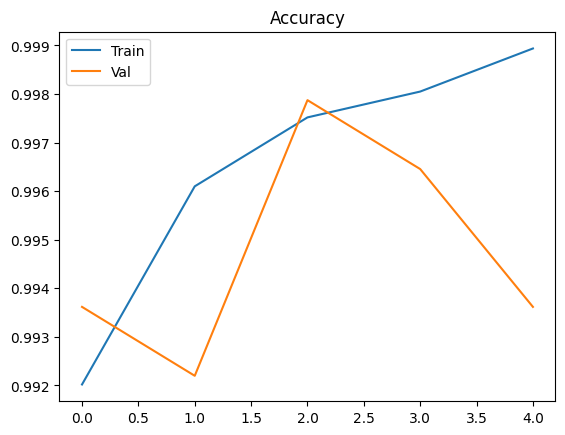

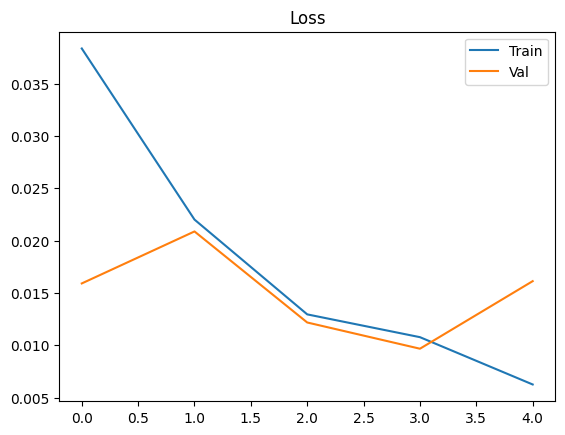

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train','Val'])
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Val'])
plt.title("Loss")
plt.show()

In [17]:
model.save("drowsiness_model.h5")